# import


In [47]:
# 3. 能量响应分析：发射能量 vs 沉积能量
import matplotlib.pyplot as plt


# 检查 ROOT 文件中的所有分支
import uproot
import os

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import importlib
import data_loader

importlib.reload(data_loader)
from data_loader import load_and_process_data

from matplotlib.colors import LogNorm

## DataLoading

In [26]:
# 检查 ROOT 文件中的所有分支
import uproot
import os

root_file = "data/res2.root"
file = uproot.open(root_file)
tree = file["CsI"]

print("ROOT 文件中的所有分支:")
print("=" * 60)
for branch_name in tree.keys():
    branch = tree[branch_name]
    print(f"{branch_name:30s} {branch.typename}")
print("=" * 60)

ROOT 文件中的所有分支:
EventID                        int32_t
TotalEdep                      double
HitCount                       int32_t
CrystalID                      std::vector<int32_t>
CrystalEdep                    std::vector<double>
CrystalTime                    std::vector<double>
CrystalPosX                    std::vector<double>
CrystalPosY                    std::vector<double>
CrystalPosZ                    std::vector<double>
CrystalPDG                     std::vector<int32_t>
CrystalParentID                std::vector<int32_t>
CrystalDirX                    std::vector<double>
CrystalDirY                    std::vector<double>
CrystalDirZ                    std::vector<double>
CrystalKineticEnergy           std::vector<double>
CrystalProcessID               std::vector<int32_t>
PrimaryPDG                     std::vector<int32_t>
PrimaryEnergy                  std::vector<double>
PrimaryPosX                    std::vector<double>
PrimaryPosY                    std::vector<doubl

In [27]:
# 删除旧的缓存文件，以便重新生成包含所有分支的数据
import os

cache_file = "data/res2_hits.parquet"
if os.path.exists(cache_file):
    os.remove(cache_file)
    print(f"已删除旧缓存: {cache_file}")

已删除旧缓存: data/res2_hits.parquet


In [30]:
# ================== 读取与预处理数据 ==================

from data_loader import load_and_process_data

# 配置路径
root_file = "data/res2.root"
output_dir = "plots"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    # 一键加载并预处理 (会自动读取/生成 parquet 缓存)
    # 注意：现在返回 5 个值，增加了 df_primaries
    data, df_hits, df_primaries, process_map, num_events = load_and_process_data(root_file, cache=True)

    print("\nDataFrame Preview (Hits):")
    print(df_hits.head())

    print("\nDataFrame Preview (Primaries):")
    print(df_primaries.head())

    # 为了兼容后面的绘图代码，将 DataFrame 列赋值给变量
    # 注意：这里直接使用 DataFrame 的列，它们已经是 numpy array 或 Series
    flat_edep = df_hits["edep"]
    flat_time = df_hits["time"]
    flat_posX = df_hits["posX"]
    flat_posY = df_hits["posY"]
    flat_pdg = df_hits["pdg"]
    flat_process = df_hits["processID"]
    flat_id = df_hits["crystalID"]

except Exception as e:
    print(f"Error: {e}")
    import traceback

    traceback.print_exc()

[Info] Loaded 7 processes from 'data/res2_ProcessIDMap.txt'
Opening ROOT file: data/res2.root...
Successfully loaded 50000 events from ROOT.
Converting to Pandas DataFrames...
Processing Primary particles...
Saving DataFrame caches...

DataFrame Preview (Hits):
   EventID  hit_idx      edep      time        posX        posY        posZ  \
0        0        0  0.246478  0.012446  243.500000 -217.280024  -63.638601   
1        1        0  5.926113  0.000000   -9.942948 -226.133243 -149.076349   
2        2        0  2.846352  0.000000   50.612061 -214.194216  134.017125   
3        2        1  0.510999  0.086264   77.145706 -224.374424  127.273105   
4        3        0  4.773440  0.000000  142.478758   12.545274  -14.164356   

   pdg  parentID      dirX      dirY      dirZ  kineticEnergy  processID  \
0   11         0 -0.994459 -0.066552  0.081382       0.331854          0   
1  -11         0  0.413241 -0.754058 -0.510518       2.568682          0   
2  -11         0  0.147713  0.95475

# Process

In [42]:
# ================== 关联发射粒子与探测器 Hit ==================

# 1. 将发射粒子信息合并到 Hit 数据中
# 我们使用 EventID 作为键进行合并
# suffixes=('_hit', '_primary') 用于区分同名列 (如 pdg, posX 等)
df_merged = pd.merge(df_hits, df_primaries, on="EventID", suffixes=("_hit", "_primary"))

print("合并后的 DataFrame (前 5 行):")
# 选取一些关键列进行展示
cols_to_show = ["EventID", "edep", "pdg_hit", "parentID", "pdg_primary", "energy"]
print(df_merged[cols_to_show].head())

# 2. 区分 Hit 是由初级粒子直接产生，还是由次级粒子产生
# 在 Geant4 中，通常 ParentID = 0 表示该径迹是初级粒子
# 如果 parentID == 0，说明产生这个 Hit 的粒子就是发射的粒子本身
primary_hits = df_merged[df_merged["parentID"] == 0]
secondary_hits = df_merged[df_merged["parentID"] > 0]

print(f"\n统计信息:")
print(f"  总 Hits 数: {len(df_merged)}")
print(f"  初级粒子直接产生的 Hits: {len(primary_hits)} ({len(primary_hits) / len(df_merged):.1%})")
print(f"  次级粒子产生的 Hits: {len(secondary_hits)} ({len(secondary_hits) / len(df_merged):.1%})")

合并后的 DataFrame (前 5 行):
   EventID      edep  pdg_hit  parentID  pdg_primary    energy
0        0  0.246478       11         0           11  0.843090
1        0  0.246478       11         0          -11  0.843090
2        1  5.926113      -11         0           11  3.079680
3        1  5.926113      -11         0          -11  3.079680
4        2  2.846352      -11         0           11  1.678676

统计信息:
  总 Hits 数: 213048
  初级粒子直接产生的 Hits: 105294 (49.4%)
  次级粒子产生的 Hits: 107754 (50.6%)


In [ ]:
# 按 EventID 分组计算总沉积能量
event_edep = df_hits.groupby("EventID")["edep"].sum().reset_index()
event_edep.rename(columns={"edep": "total_edep"}, inplace=True)

# 合并发射能量信息
# 注意：一个事件可能有多个发射粒子，这里我们计算每个事件的总发射能量
event_primary = df_primaries.groupby("EventID")["energy"].sum().reset_index()
event_primary.rename(columns={"energy": "total_primary_energy"}, inplace=True)

# 合并两个统计结果
df_energy_corr = pd.merge(event_edep, event_primary, on="EventID")

In [51]:
df_hits

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
0,0,0,0.246478,0.012446,243.500000,-217.280024,-63.638601,11,0,-0.994459,-0.066552,0.081382,0.331854,0,70001,7,0,1
1,1,0,5.926113,0.000000,-9.942948,-226.133243,-149.076349,-11,0,0.413241,-0.754058,-0.510518,2.568682,0,30000,3,0,0
2,2,0,2.846352,0.000000,50.612061,-214.194216,134.017125,-11,0,0.147713,0.954757,0.258108,1.167677,0,40004,4,0,4
3,2,1,0.510999,0.086264,77.145706,-224.374424,127.273105,22,2,0.946232,0.031271,0.321972,0.108472,1,50004,5,0,4
4,3,0,4.773440,0.000000,142.478758,12.545274,-14.164356,-11,0,0.567180,0.542932,-0.619299,2.471743,0,60402,6,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106519,49997,0,0.009116,0.894275,-243.500000,-135.381541,-83.528423,11,0,0.820297,0.541786,-0.183250,0.060671,0,101,0,1,1
106520,49998,0,3.091280,0.000000,154.036942,-8.196042,-65.305403,-11,0,0.585762,0.801052,-0.123281,1.034641,0,60301,6,3,1
106521,49999,0,5.585036,0.000000,-27.663736,220.092665,-60.484416,-11,0,-0.657693,0.223672,0.719312,2.732339,0,30701,3,7,1
106522,49999,1,0.427993,0.130774,7.044962,214.387723,-49.620945,22,2,-0.579979,0.814085,0.029849,0.177622,1,40701,4,7,1


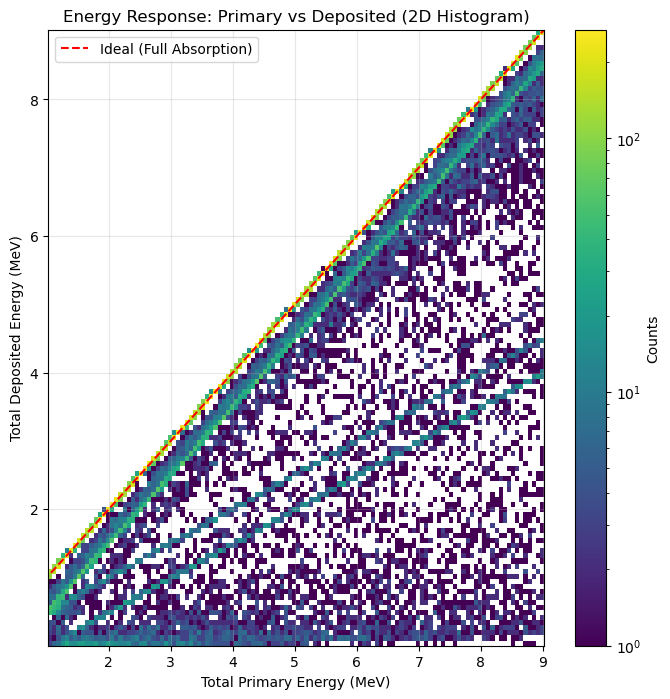

In [49]:
# 绘图 1: 能量响应二维直方图
plt.figure(figsize=(8, 8))
counts, xedges, yedges, image = plt.hist2d(
    df_energy_corr["total_primary_energy"],
    df_energy_corr["total_edep"],
    bins=(120, 120),
    norm=LogNorm(),
    cmap="viridis",
)
plt.colorbar(image, label="Counts")
# 绘制 y=x 参考线
max_e = max(df_energy_corr["total_primary_energy"].max(), df_energy_corr["total_edep"].max())
plt.plot([0, max_e], [0, max_e], "r--", label="Ideal (Full Absorption)")

plt.xlabel("Total Primary Energy (MeV)")
plt.ylabel("Total Deposited Energy (MeV)")
plt.title("Energy Response: Primary vs Deposited (2D Histogram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
pd.read_parquet("data/res2_primaries.parquet")

,EventID,primary_idx,pdg,energy,posX,posY,posZ,dirX,dirY,dirZ
0,0,0,11,0.843090,246.423384,-216.977166,-64.050394,-0.985055,-0.102050,0.138757
1,0,1,-11,0.843090,246.423384,-216.977166,-64.050394,0.985055,0.102050,-0.138757
2,1,0,11,3.079680,-9.942948,-226.133243,-149.076349,-0.413241,0.754058,0.510518
3,1,1,-11,3.079680,-9.942948,-226.133243,-149.076349,0.413241,-0.754058,-0.510518
4,2,0,11,1.678676,50.612061,-214.194216,134.017125,-0.147713,-0.954757,-0.258108
...,...,...,...,...,...,...,...,...,...,...
99995,49997,1,-11,0.652990,-246.468654,-242.817614,-136.094477,-0.395830,-0.910893,0.116589
99996,49998,0,11,1.545640,154.036942,-8.196042,-65.305403,-0.585762,-0.801052,0.123281
99997,49998,1,-11,1.545640,154.036942,-8.196042,-65.305403,0.585762,0.801052,-0.123281
99998,49999,0,11,3.243338,-27.663736,220.092665,-60.484416,0.657693,-0.223672,-0.719312


In [32]:
cache_file = "data/res2_primaries.parquet"
if os.path.exists(cache_file):
    os.remove(cache_file)
    print(f"已删除旧缓存: {cache_file}")
cache_file

已删除旧缓存: data/res2_primaries.parquet


'data/res2_primaries.parquet'

In [ ]:
res2_primaries.parquet

In [35]:
# 查看 DataFrame 的完整信息
print("\n数据集信息:")
print(f"总事件数: {num_events}")
print(f"总 Hit 数: {len(df_hits)}")
print(f"\nDataFrame 列:")
for col in df_hits.columns:
    print(f"  - {col:20s} (类型: {df_hits[col].dtype})")

print(f"\n数据统计:")
print(df_hits.describe())


数据集信息:
总事件数: 50000
总 Hit 数: 106524

DataFrame 列:
  - EventID              (类型: int64)
  - hit_idx              (类型: int64)
  - edep                 (类型: float64)
  - time                 (类型: float64)
  - posX                 (类型: float64)
  - posY                 (类型: float64)
  - posZ                 (类型: float64)
  - pdg                  (类型: int32)
  - parentID             (类型: int32)
  - dirX                 (类型: float64)
  - dirY                 (类型: float64)
  - dirZ                 (类型: float64)
  - kineticEnergy        (类型: float64)
  - processID            (类型: int32)
  - crystalID            (类型: int32)
  - ix                   (类型: int32)
  - iy                   (类型: int32)
  - iz                   (类型: int32)

数据统计:
             EventID        hit_idx           edep           time  \
count  106524.000000  106524.000000  106524.000000  106524.000000   
mean    25002.544478       0.878675       1.988909       0.097721   
std     14424.379870       1.050690       2.269432  

In [10]:
# 查看返回值的详细信息
print("=" * 60)
print("load_and_process_data() 返回值说明:")
print("=" * 60)

print("\n1. data (Awkward Array):")
print(f"   类型: {type(data)}")
print(f"   形状: {len(data)} 个事件")
print(f"   包含字段: {data.fields}")
print(f"   说明: 这是原始的 ROOT 数据，保持了事件的层次结构")
print(f"   示例: data['TotalEdep'] 是每个事件的总能量沉积")

print("\n2. df_hits (Pandas DataFrame):")
print(f"   类型: {type(df_hits)}")
print(f"   形状: {df_hits.shape} (行数 × 列数)")
print(f"   说明: 这是展平后的 Hit 级别数据，每一行代表一个 Hit")
print(f"   列名: {list(df_hits.columns)}")

print("\n3. process_map (字典):")
print(f"   类型: {type(process_map)}")
print(f"   大小: {len(process_map)} 个物理过程")
print(f"   说明: ProcessID → 过程名称的映射")
print(f"   示例: {dict(list(process_map.items())[:5])}")

print("\n4. num_events (整数):")
print(f"   类型: {type(num_events)}")
print(f"   值: {num_events}")
print(f"   说明: 总事件数")

print("\n" + "=" * 60)

load_and_process_data() 返回值说明:

1. data (Awkward Array):
   类型: <class 'awkward.highlevel.Array'>
   形状: 50000 个事件
   包含字段: ['EventID', 'TotalEdep', 'HitCount', 'CrystalID', 'CrystalEdep', 'CrystalTime', 'CrystalPosX', 'CrystalPosY', 'CrystalPosZ', 'CrystalPDG', 'CrystalParentID', 'CrystalDirX', 'CrystalDirY', 'CrystalDirZ', 'CrystalKineticEnergy', 'CrystalProcessID']
   说明: 这是原始的 ROOT 数据，保持了事件的层次结构
   示例: data['TotalEdep'] 是每个事件的总能量沉积

2. df_hits (Pandas DataFrame):
   类型: <class 'pandas.core.frame.DataFrame'>
   形状: (104850, 18) (行数 × 列数)
   说明: 这是展平后的 Hit 级别数据，每一行代表一个 Hit
   列名: ['EventID', 'hit_idx', 'edep', 'time', 'posX', 'posY', 'posZ', 'pdg', 'parentID', 'dirX', 'dirY', 'dirZ', 'kineticEnergy', 'processID', 'crystalID', 'ix', 'iy', 'iz']

3. process_map (字典):
   类型: <class 'dict'>
   大小: 5 个物理过程
   说明: ProcessID → 过程名称的映射
   示例: {0: 'Primary', 1: 'annihil', 2: 'compt', 4: 'conv', 3: 'eBrem'}

4. num_events (整数):
   类型: <class 'int'>
   值: 50000
   说明: 总事件数



In [12]:
df_hits

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
0,0,0,0.290272,0.012849,243.500000,-217.280024,-63.638601,11,0,-0.995292,-0.062191,0.074340,0.290272,0,70001,7,0,1
1,1,0,3.729834,0.000000,-16.199048,224.674826,-148.459765,-11,0,-0.892142,0.041292,-0.449863,1.609417,0,30700,3,7,0
2,2,0,6.567498,0.000000,103.964251,239.040473,-29.058119,-11,0,-0.641936,0.215979,-0.735712,3.028250,0,50702,5,7,2
3,3,0,1.496094,0.000000,-97.316725,15.587585,143.700723,-11,0,-0.434871,0.164118,0.885411,0.418953,0,20404,2,4,4
4,4,0,4.177339,0.000000,120.120463,-235.808632,-9.094943,-11,0,-0.638876,-0.679499,-0.360718,2.088669,0,50002,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104845,49998,0,3.289545,0.000000,-16.274750,153.871976,43.786372,-11,0,0.688594,-0.645357,-0.330685,1.644772,0,30603,3,6,3
104846,49998,1,0.510999,0.280818,-21.356087,92.281992,124.647650,22,2,0.807326,-0.538462,0.241420,0.272817,1,30504,3,5,4
104847,49998,2,0.510999,0.290103,-12.943968,192.667392,-34.859046,22,2,0.892319,-0.387043,0.232302,0.235411,1,30701,3,7,1
104848,49999,0,3.297206,0.000000,92.841321,-164.451023,111.037741,-11,0,0.462652,-0.762083,-0.452970,1.393104,0,50104,5,1,4


In [11]:
df_hits
event_id_counts = df_hits["EventID"].value_counts().sort_index().rename("hit_count").to_frame()
event_id_counts[event_id_counts["hit_count"] > 6]

,hit_count
EventID,
476,7
502,7
514,11
1171,8
1282,7
...,...
46459,7
48185,7
48374,8


In [92]:
df_hits[df_hits["EventID"] == 514]

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
1059,514,0,2.158392,0.225707,60.500000,-40.520601,-32.860805,-11,0,-0.067199,0.941348,0.330679,2.158392,0,40301,4,3,1
1060,514,1,0.296210,0.406665,61.964335,-77.752994,-8.869295,22,2,0.795128,-0.604728,-0.045561,0.296210,1,50202,5,2,2
1061,514,2,0.195359,0.377567,54.856521,-72.779330,-7.953982,11,6,-0.633634,-0.504049,0.586892,0.195359,2,40202,4,2,2
1062,514,3,0.019430,0.276466,59.027709,-47.210002,-23.684732,11,6,0.106667,0.513002,0.851734,0.019430,2,40302,4,3,2
1063,514,4,0.452671,0.728250,85.135017,61.500000,-135.536790,22,2,0.385951,0.573539,-0.722562,0.452671,1,50500,5,5,0
1064,514,5,0.031582,0.579539,70.584435,39.877249,-108.295789,11,5,-0.927275,0.290535,-0.236115,0.026919,2,50400,5,4,0
1065,514,6,0.017357,0.498138,65.893360,20.256888,-84.455478,11,5,-0.462757,0.732902,0.498708,0.017357,2,50401,5,4,1
1066,514,7,0.009389,0.335082,63.402984,-18.718985,-55.057716,11,5,0.273580,-0.591691,-0.758325,0.009389,2,50301,5,3,1
1067,514,8,0.170906,0.050128,61.500000,-120.042994,-49.317603,11,0,0.019765,-0.981013,-0.192932,2.165107,0,50201,5,2,1
1068,514,9,0.138481,0.057717,60.500000,-121.253887,-47.954044,11,0,-0.537425,-0.519159,0.664566,1.994718,0,40201,4,2,1


In [ ]:
np.sum(df_hits[df_hits["EventID"] == 514])

np.float64(5.3458323389604026)

In [3]:
# ================== 绘图分析 ==================
import matplotlib.pyplot as plt

# 1. 总能量沉积谱
plt.figure(figsize=(10, 6))
plt.hist(data["TotalEdep"], bins=100, range=(0, max(data["TotalEdep"]) * 1.1), histtype="stepfilled", alpha=0.7, label="Total Edep")
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.title(f"Total Energy Deposition per Event ({num_events} events)")
plt.grid(True, alpha=0.3)
plt.show()


NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

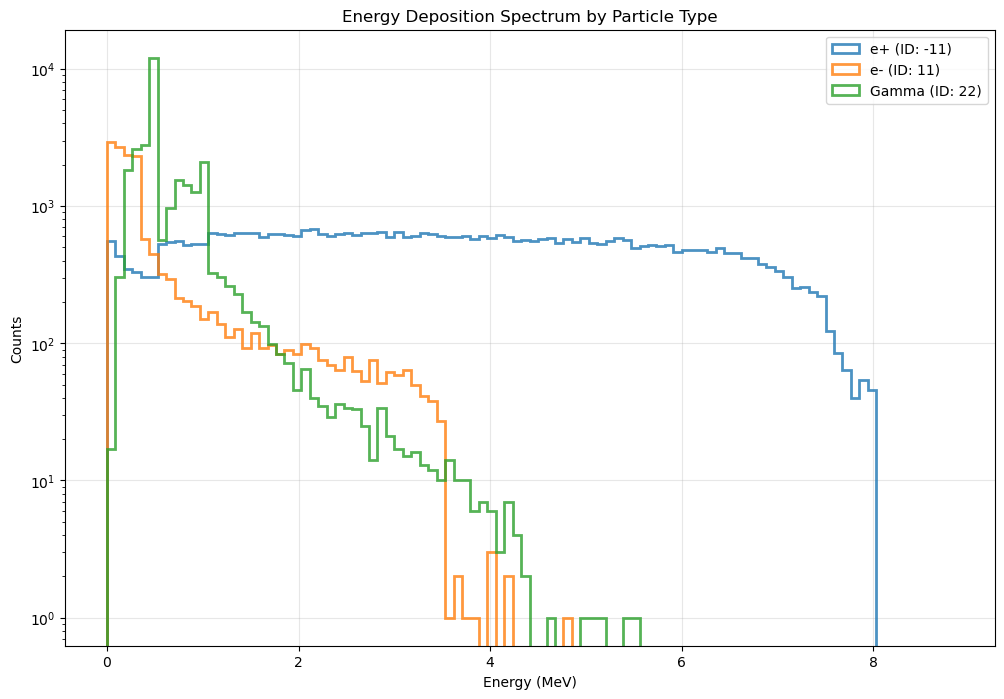

In [51]:
# 1.1 不同粒子类型的能量沉积谱
# 我们需要将每个 Hit 的能量沉积按粒子类型分类，然后累加到每个事件中

# 获取所有唯一的粒子类型
unique_pdgs = np.unique(flat_pdg)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}

plt.figure(figsize=(12, 8))

# 遍历每种粒子类型
for pid in unique_pdgs:
    # 创建掩码：选择当前粒子类型的 Hit
    mask = data["CrystalPDG"] == pid

    # 计算该粒子类型在每个事件中的总能量沉积
    # ak.sum(..., axis=-1) 会对每个事件内的 Hit 求和
    edep_per_event = ak.sum(data["CrystalEdep"][mask], axis=-1)

    # 过滤掉能量为 0 的事件（即该事件中没有这种粒子的沉积）
    edep_per_event = edep_per_event[edep_per_event > 0]

    if len(edep_per_event) > 0:
        label = f"{pdg_names.get(pid, str(pid))} (ID: {pid})"
        plt.hist(edep_per_event, bins=100, range=(0, max(data["TotalEdep"]) * 1.1), histtype="step", linewidth=2, label=label, alpha=0.8)

plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.title(f"Energy Deposition Spectrum by Particle Type")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")  # 使用对数坐标，因为不同粒子的贡献可能相差很大
plt.show()

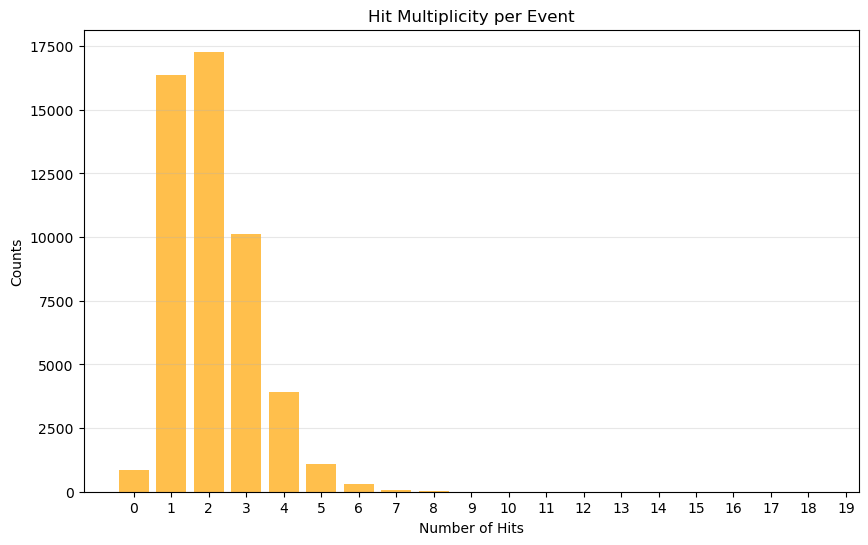

In [32]:
# 2. 击中数分布
plt.figure(figsize=(10, 6))
plt.hist(data["HitCount"], bins=range(0, 20), align="left", rwidth=0.8, color="orange", alpha=0.7)
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.title("Hit Multiplicity per Event")
plt.xticks(range(0, 20))
plt.grid(True, axis="y", alpha=0.3)
plt.show()


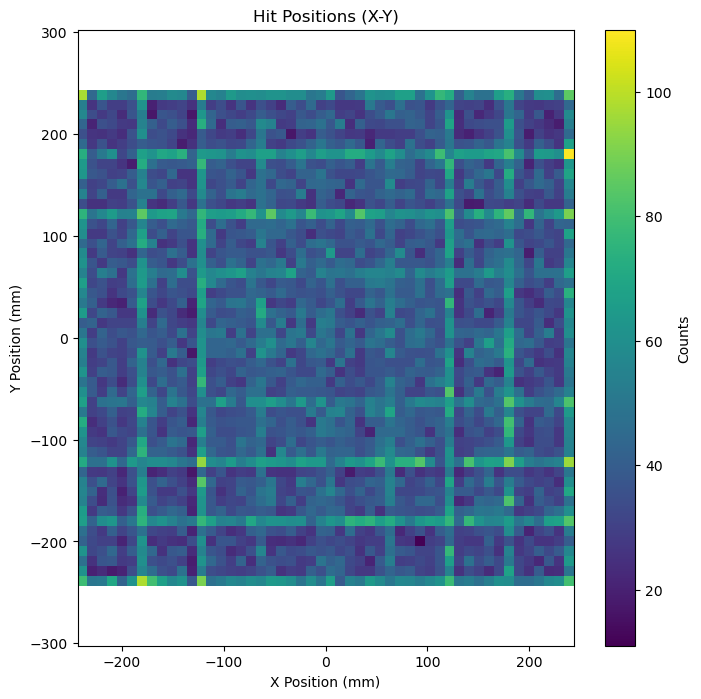

In [33]:
# 3. 击中位置分布 (Hit Positions X-Y)
plt.figure(figsize=(8, 8))
plt.hist2d(flat_posX, flat_posY, bins=50, cmap="viridis", cmin=1)
plt.colorbar(label="Counts")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.title("Hit Positions (X-Y)")
plt.axis("equal")
plt.show()


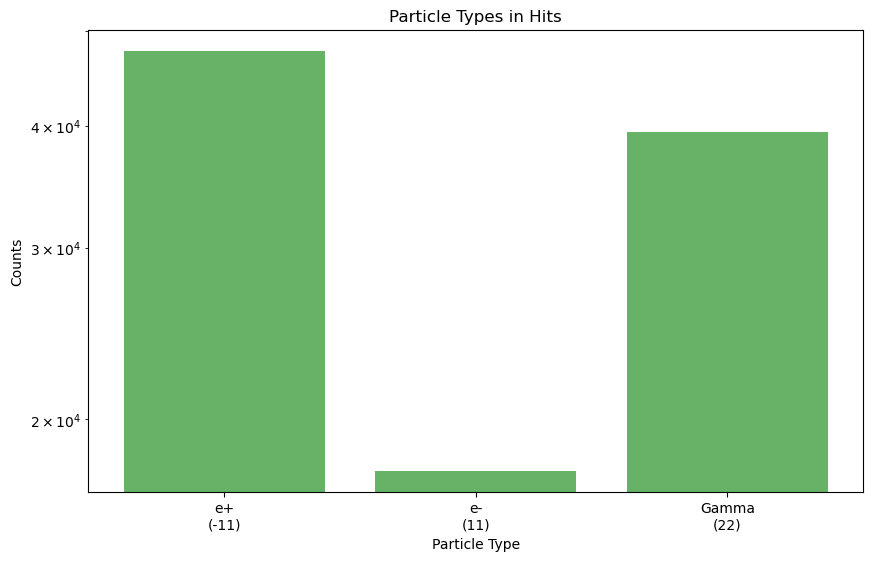

In [34]:
# 4. 粒子类型分布
unique_pdgs, counts = np.unique(flat_pdg, return_counts=True)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}
labels = [f"{pdg_names.get(pid, str(pid))}\n({pid})" for pid in unique_pdgs]

plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_pdgs)), counts, tick_label=labels, color="green", alpha=0.6)
plt.xlabel("Particle Type")
plt.ylabel("Counts")
plt.title("Particle Types in Hits")
plt.yscale("log")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


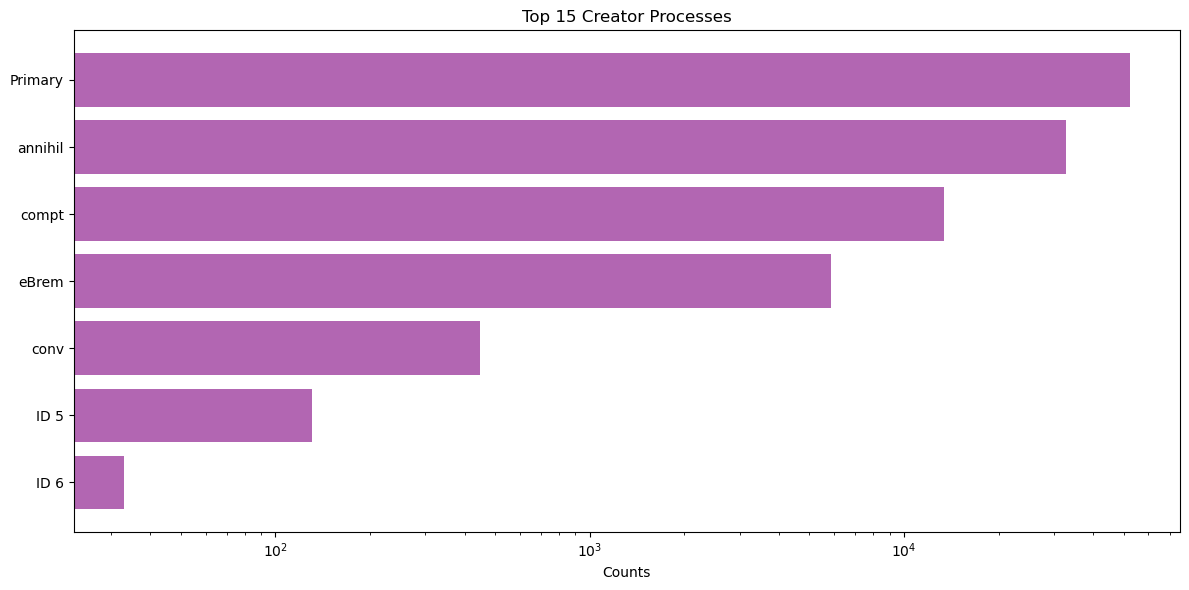

In [35]:
# 5. 物理过程分布
unique_procs, proc_counts = np.unique(flat_process, return_counts=True)
proc_labels = [process_map.get(pid, f"ID {pid}") for pid in unique_procs]

sorted_indices = np.argsort(proc_counts)[::-1]
sorted_counts = proc_counts[sorted_indices]
sorted_labels = np.array(proc_labels)[sorted_indices]

top_n = 15
if len(sorted_counts) > top_n:
    sorted_counts = sorted_counts[:top_n]
    sorted_labels = sorted_labels[:top_n]

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_counts)), sorted_counts, color="purple", alpha=0.6)
plt.yticks(range(len(sorted_counts)), sorted_labels)
plt.xlabel("Counts")
plt.title(f"Top {top_n} Creator Processes")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.tight_layout()
plt.show()


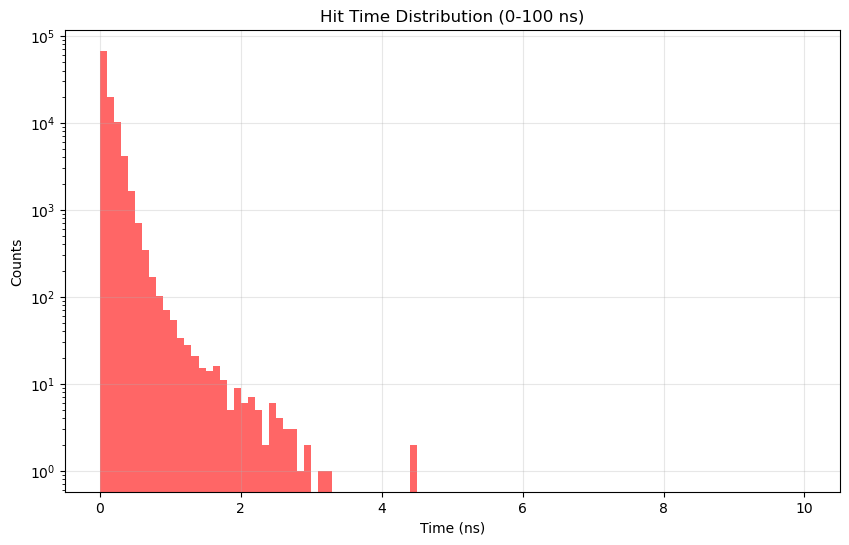

In [36]:
# 6. 时间分布
plt.figure(figsize=(10, 6))
plt.hist(flat_time, bins=100, range=(0, 10), color="red", alpha=0.6)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.title("Hit Time Distribution (0-100 ns)")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()